In [1]:
!apt-get install aria2 > /dev/null

In [2]:
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip > /dev/null 
!aria2c -x 16 -s 16 https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip > /dev/null

In [3]:
!unzip /content/Flickr8k_Dataset.zip > /dev/null
!unzip /content/Flickr8k_text.zip > /dev/null
!rm *.zip > /dev/null

In [4]:
import os
import re
import numpy as np
import collections
from PIL import Image
from textwrap import wrap
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tqdm import tqdm_notebook as tqdm

from keras.models import Model
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications.xception import Xception
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


In [5]:
def clean_description(desc, stopwords):

  cleaned = desc.lower()
  cleaned = re.sub('[^a-z]',' ',cleaned)
  tokens = cleaned.split(' ')
  cleaned = ' '.join([w for w in tokens if w not in stopwords and len(w)>1])
  
  return cleaned

In [6]:
def get_vocabulary(dictionary):
  vocab = set()

  for desc_list in dictionary.values():
    for desc in desc_list:
      words = desc.split(' ')
      for word in words:
        vocab.add(word)

  return vocab

In [7]:
with open('/content/Flickr8k.token.txt', 'r') as f:
  all_desc = f.read().split('\n')

In [8]:
# Some sample data
all_desc[:5]

['1000268201_693b08cb0e.jpg#0\tA child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg#1\tA girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg#2\tA little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg#3\tA little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg#4\tA little girl in a pink dress going into a wooden cabin .']

In [9]:
stopwords = ['is', 'an', 'a', 'the', 'was']

In [10]:
all_dict = dict()

for desc in all_desc:
  if len(desc) < 1:
    continue
  file_name, file_desc = desc.split('\t')[0].split('.')[0], desc.split('\t')[1]
  
  if file_name not in all_dict.keys():
    all_dict[file_name] = []

  cleaned_desc = clean_description(file_desc, stopwords)
  cleaned_desc = 'startseq ' + cleaned_desc + ' endseq'

  all_dict[file_name].append(cleaned_desc)

In [11]:
vocab = get_vocabulary(all_dict)

In [12]:
print('Total images:', len(all_dict))
print('Total vocabulary without stopwords:', len(vocab))

Total images: 8092
Total vocabulary without stopwords: 8423


In [13]:
!wget https://banner2.cleanpng.com/20181128/vpu/kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg > /dev/null

--2020-06-29 17:28:32--  https://banner2.cleanpng.com/20181128/vpu/kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg
Resolving banner2.cleanpng.com (banner2.cleanpng.com)... 172.64.109.22, 172.64.108.22, 2606:4700:e0::ac40:6c16, ...
Connecting to banner2.cleanpng.com (banner2.cleanpng.com)|172.64.109.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22116 (22K) [image/jpeg]
Saving to: ‘kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg’

kisspng-cloud-compu 100%[===================>]  21.60K  --.-KB/s    in 0s      

2020-06-29 17:28:33 (103 MB/s) - ‘kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg’ saved [22116/22116]



In [14]:
mask = np.array(Image.open('kisspng-cloud-computing-scalable-vector-graphics-joruri-po-5bfe80dc1e3ab9.9777518815434057881238.jpg'))

wordcloud = WordCloud(width = 500, height = 400, 
                  background_color ='black', 
                  min_font_size = 10,
                  mask=mask, random_state=0).generate(' '.join(vocab)) 

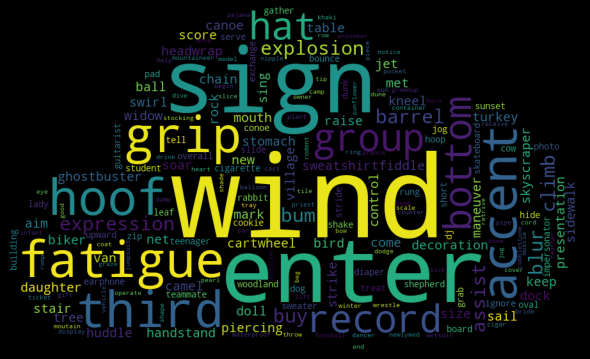

In [15]:
plt.figure(figsize = (8, 8), facecolor = 'k', edgecolor = 'k' ) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

In [16]:
all_sent_list = [item.strip('startseq').strip('endseq').strip(' ') for sublist in list(all_dict.values()) for item in sublist]

In [17]:
all_sent_len = [len(sent) for sent in all_sent_list]

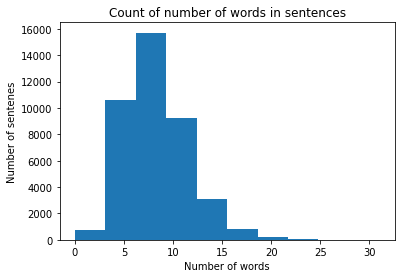

In [18]:
plt.hist([len(sentence.split()) for sentence in all_sent_list])
plt.xlabel('Number of words')
plt.ylabel('Number of sentenes')
plt.title('Count of number of words in sentences')
plt.show()

In [19]:
avg_sent_len = int(np.mean([len(sentence.split()) for sentence in all_sent_list]))
avg_sent_len

8

In [20]:
words = [w for a in all_sent_list for w in a.split(' ')]

In [21]:
counts = collections.Counter(words)
most_common = counts.most_common()
most_common[:15]

[('in', 18987),
 ('on', 10746),
 ('and', 8863),
 ('dog', 8138),
 ('with', 7765),
 ('man', 7275),
 ('of', 6723),
 ('two', 5643),
 ('white', 3959),
 ('black', 3848),
 ('boy', 3581),
 ('are', 3505),
 ('woman', 3403),
 ('girl', 3328),
 ('to', 3176)]

In [22]:
keys = [tupl[0] for tupl in most_common][:15]
values = [tupl[1] for tupl in most_common][:15]

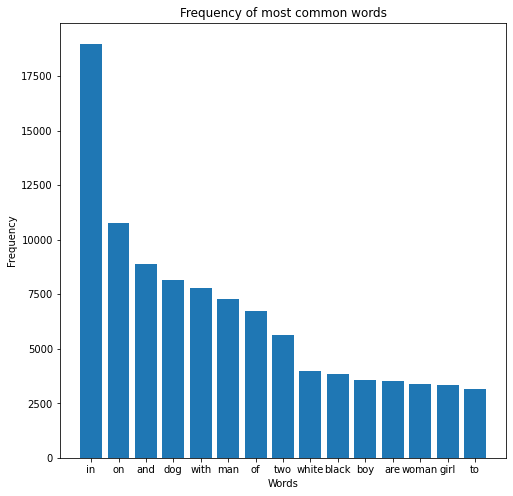

In [23]:
plt.figure(figsize=(8, 8))
plt.bar(keys, values)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Frequency of most common words')
plt.show()

In [24]:
lengths = set()
for cap_list in all_dict.values():
  lengths.add(len(cap_list))

print('Number of captions for each image: ', lengths)

Number of captions for each image:  {5}


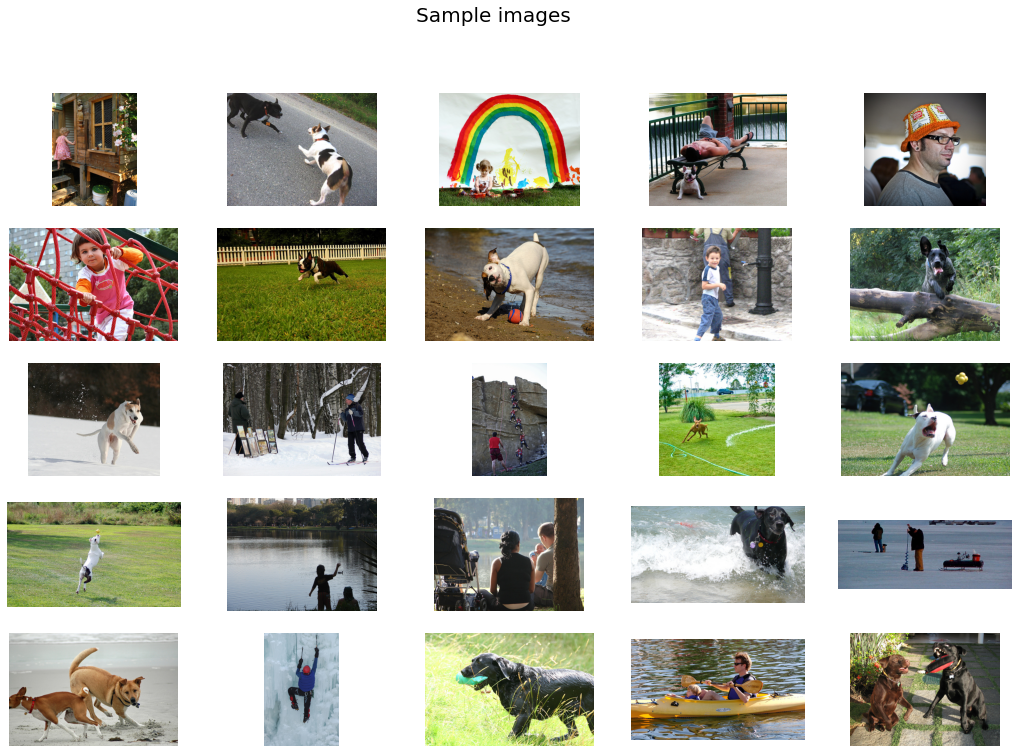

In [25]:
fig = plt.figure()
fig.suptitle('Sample images', fontsize=20)

zoom = 3
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)
fig.tight_layout()

for i in range(1, 26):
  ax = fig.add_subplot(5, 5, i)
  ax.imshow(plt.imread('Flicker8k_Dataset/'+list(all_dict.keys())[i-1]+'.jpg'))
  plt.axis('off')

plt.show()

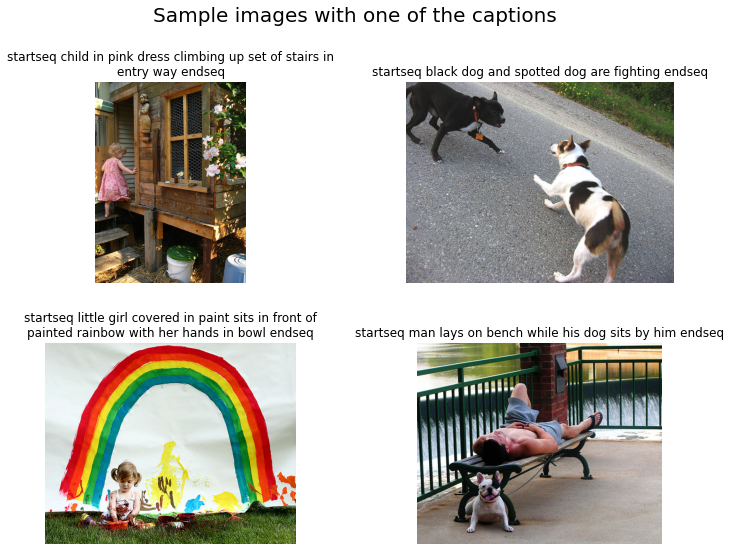

In [26]:
fig = plt.figure()
fig.suptitle('Sample images with one of the captions', fontsize=20)

zoom = 2
w, h = fig.get_size_inches()
fig.set_size_inches(w * zoom, h * zoom)

for i in range(1, 5):
  ax = fig.add_subplot(2, 2, i)
  ax.imshow(plt.imread('Flicker8k_Dataset/'+list(all_dict.keys())[i-1]+'.jpg'))
  title = ax.set_title('\n'.join(wrap(all_dict.get(list(all_dict.keys())[i-1])[0], 60)))
  fig.tight_layout(h_pad=2)
  title.set_y(1.05)
  plt.axis('off')
  fig.subplots_adjust(top=0.85, hspace=0.3)

plt.show()

In [27]:
xcep = Xception(include_top=False, pooling='avg')

83689472/83683744 [==============================] - 1s 0us/step


In [28]:
xcep.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [29]:
predictions = dict()

for dirpath, dirname, files in os.walk('Flicker8k_Dataset'):
  for filename in tqdm(files):
    img_path = os.path.join(dirpath, filename)
    if os.path.isfile(img_path):
      img = Image.open(img_path)
      img = img.resize((299,299))
      img = np.expand_dims(img, axis=0)
      img = img/127.5
      img = img - 1.0

      predictions[filename.split('.')[0]] = xcep.predict(img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [40]:
print('Number of extracted features:', len(predictions.get(list(predictions.keys())[0])[0]))

Number of extracted features: 2048


In [42]:
predictions.get(list(predictions.keys())[0])

array([[0.35896724, 0.2671607 , 0.        , ..., 0.        , 0.04131206,
        0.04455593]], dtype=float32)